Develop a simulation algorithm based on historical returns data of profitable traders. </br>
~Create a model to map various possible future returns within specified timeframes (weekly and monthly).~ </br>
~Define the expected upper and lower bound of our set criteria, and the probability of negative returns at each confidence interval.~ </br>
~Monitor and adjust the model based on the position size for each trader (methodology will be provided).~</br>
~Perform numerous simulation runs~ and keep track of trades and adjusted balances. </br>
~Interpret the results from the simulations to define potential return ranges and worst-case scenarios.~ </br>
~Analyze confidence intervals to understand the probability of specific returns (win and loss) at the end of the time duration.~</br>
Make necessary adjustments in parameters or the algorithm to enhance the accuracy of the model.</br>

Time is a factor. Check how much x trader makes in a week or month. Highest and lowest in a given week, highest and lowest in a given month.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as skl
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import os
import datetime
import random
import scipy.integrate as integrate
import secrets
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
def float_range(start, stop, step=1.0):
    current = start
    array = []
    while current < stop:
        array.append(current)
        current += step
    return array

def confidenceInterval(data, confidence=99):
    sample_mean = np.mean(data)
    sample_std_dev = np.std(data, ddof=1)  # ddof=1 for sample standard deviation
    sample_size = len(data)
    standard_error = sample_std_dev / np.sqrt(sample_size)
    confidence_interval = stats.t.interval(confidence / 100, df=sample_size - 1, loc=sample_mean, scale=standard_error)
    return confidence_interval


def bootstrap(data, numSim):
    bootstrapSamples = []
    for _ in range(numSim):
        bootstrapSample = np.random.choice(data, size=len(data), replace=True)
        bootstrapSamples.append(bootstrapSample)
    return bootstrapSamples

In [4]:
df = pd.read_csv("rajarshi dataset.csv");
df['price'] = (df['pnl'] - df['fee']) / (df['volume'] * df['return'])

In [5]:
traders = df['trader'].unique();
profitableTraders = [];
for trader in traders:
    if df[df['trader'] == trader]['return'].sum() > 0: profitableTraders.append(trader);
if not os.path.exists('./Plots') and not os.path.isdir('./Plots'):
    os.makedirs('./Plots/');
if len(os.listdir('./Plots/')) == 0:
    for trader in profitableTraders:
        returnData = np.array(df[df['trader'] == trader]['return'].values.tolist());
        ax = sns.distplot(returnData, bins=50, kde=True, color='red', hist_kws={"linewidth": 15,'alpha':1});
        ax.set(xlabel='Normal Distribution', ylabel='Frequency');
        plt.savefig("./Plots/" + trader + ".png")

In [6]:
def simulate_trading_strategy(returns_data, initial_capital):
    # Calculate the daily returns
    daily_returns = np.log(1 + returns_data)
    print(daily_returns);

    # Calculate the cumulative returns
    cumulative_returns = np.cumsum(daily_returns, axis=0)

    # Calculate the average daily return and volatility
    avg_daily_return = np.mean(daily_returns, axis=0)
    volatility = np.std(daily_returns, axis=0)

    # Generate random simulations
    simulation_results = []
    for _ in range(1000):
        random_daily_returns = np.random.normal(avg_daily_return, volatility)
        simulation_cumulative_returns = np.cumsum(random_daily_returns) + np.log(initial_capital)
        simulation_results.append(simulation_cumulative_returns)

    return simulation_results

# Example usage
returns_data = np.array([[0.01, 0.02, 0.01], [0.02, 0.01, 0.02], [0.01, 0.01, 0.02]])  # Replace with your actual returns data
initial_capital = 1000000  # Replace with your desired initial capital

simulation_results = simulate_trading_strategy(returns_data, initial_capital);
# for i in list(map(list, simulation_results)):
#     print(i);
    
# Analyze the simulation results
# ... Perform analysis, calculate metrics, plot results, etc.

[[0.00995033 0.01980263 0.00995033]
 [0.01980263 0.00995033 0.01980263]
 [0.00995033 0.00995033 0.01980263]]


Have to find the time ranges, what are upper and lower bounds?</br>
What are confidence intervals?</br></br>
Have to map out 

In [7]:
def traderPeriod(returns_data, trader, wholeRows=False, drawGraph=False, confidence=-1):
    data = returns_data[returns_data['trader'] == trader];
    minMonth = maxMonth = minWeek = maxWeek = 0;
    data['time'] = data['time'].apply(lambda x: str(x)[0:10])
    timescales = data['time'].unique();
    weeklyperiods = [];
    monthlyperiods = [];
    for timescale in timescales:
        given_date = datetime.datetime.strptime(timescale, "%Y-%m-%d").date()
        one_week_from_given_date = given_date + datetime.timedelta(days=7)
        one_month_from_given_date = given_date + datetime.timedelta(days=30)
        weeklyperiods.append((given_date.strftime("%Y-%m-%d"), one_week_from_given_date.strftime("%Y-%m-%d")));
        monthlyperiods.append((given_date.strftime("%Y-%m-%d"), one_month_from_given_date.strftime("%Y-%m-%d")));
    weeklyVals = [];
    monthlyVals = [];
    for period in weeklyperiods:
        filteredData = data[(data['time'] >= period[0]) & (data['time'] <= period[1])]
        weeklyVals.append(filteredData['return'].sum());
    for period in monthlyperiods:
        filteredData = data[(data['time'] >= period[0]) & (data['time'] <= period[1])]
        monthlyVals.append(filteredData['return'].sum());
    if drawGraph: 
        plt.hist(weeklyVals, bins=float_range(min(weeklyVals), max(weeklyVals) + 0.2, 0.2), rwidth=0.8, color='skyblue', edgecolor='black')
        plt.xlabel('Return value')
        plt.title('Weekly Example')
        plt.show()
    if confidence > 0:
        confidenceIntervalMonthly = confidenceInterval(monthlyVals)
        confidenceIntervalWeekly = confidenceInterval(weeklyVals)
        if wholeRows: return monthlyVals, weeklyVals, confidenceIntervalMonthly, confidenceIntervalWeekly;
        return min(monthlyVals), max(monthlyVals), min(weeklyVals), max(weeklyVals), confidenceIntervalMonthly, confidenceIntervalWeekly;
    if wholeRows: return monthlyVals, weeklyVals;
    return min(monthlyVals), max(monthlyVals), min(weeklyVals), max(weeklyVals);

In [8]:
def tradersPeriod(returns_data, traderList):
    weeklyMins = [];
    weeklyMaxs = [];
    monthlyMins = [];
    monthlyMaxs = [];
    for trader in traderList:
        a, b, c, d = traderPeriod(returns_data, trader);
        monthlyMins.append(a);
        monthlyMaxs.append(b);
        weeklyMins.append(c);
        weeklyMaxs.append(d);
    return (min(weeklyMins), max(weeklyMaxs)), (min(monthlyMins), max(monthlyMaxs));

In [9]:
def findClosestTrader(data, traderToEmulate, userVolume, returnRange=False):
    volumeRangeAll = list(map(lambda x: x / max(df['volume'].values.tolist()), data['volume'].values.tolist()))
    volumeRangeTrader = data[data['trader'] == traderToEmulate]['volume'].unique()
    closestVolumeAll = min(volumeRangeAll, key=lambda x: abs(x - (userVolume / max(data['volume'].values.tolist()))))
    exactVolumeTrader = closestVolumeAll * max(data[data['trader'] == traderToEmulate]['volume'].values.tolist());
    if returnRange: return sorted(volumeRangeTrader, key=lambda x: abs(x - userVolume))[:25]
    return min(volumeRangeTrader, key=lambda x: abs(x - exactVolumeTrader))

def findRandomTrader(data, traderToEmulate, returnRange=False):
    volumeRangeTrader = data[data['trader'] == traderToEmulate]['volume'].values.tolist()
    if returnRange: return random.sample(volumeRangeTrader, 25)
    else: return min(random.sample(volumeRangeTrader, 25))

In [10]:
def expectedReturnByTrader(data, traderToEmulate, userVolume, returnRange=False, random=False, sortedRange=False):
    monthlyReturns, weeklyReturns = traderPeriod(data, traderToEmulate, True);
    if random: closestVolume = findRandomTrader(data, traderToEmulate, returnRange);
    else: closestVolume = findClosestTrader(data, traderToEmulate, userVolume, returnRange);
    if returnRange:
        returns = {}
        pnls = {}
        for volume in closestVolume:
            traderRow = data[(data['volume'] == volume) & (data['trader'] == traderToEmulate)]
            fee = traderRow['fee'].iloc[0]
            price = traderRow['price'].iloc[0]
            pnl = traderRow['pnl'].iloc[0]
            returnVal = traderRow['return'].iloc[0]
            keyR = f"Price:{round(price * 1000, 2)}e-3 | Pnl:{round(pnl, 2)}"
            keyPnL = f"Price:{round(price * 1000, 2)}e-3 | Return:{round(returnVal, 2)}"
            returns[keyR] = (pnl - fee) / (userVolume * price)
            pnls[keyPnL] = (returnVal * userVolume * price) + fee
        if sortedRange: 
            return dict(sorted(returns.items(), key=lambda item: item[1])), dict(sorted(pnls.items(), key=lambda item: item[1]))
        return returns, pnls
    else:
        traderRow = data[(data['volume'] == closestVolume) & (data['trader'] == traderToEmulate)]
        fee = traderRow['fee'].iloc[0]
        price = traderRow['price'].iloc[0]
        pnl = traderRow['pnl'].iloc[0]
        returnVal = traderRow['return'].iloc[0]
        return (pnl - fee) / (userVolume * price), (returnVal * userVolume * price) + fee

# returns, pnls = expectedReturnByTrader(df, "0x618a869961c73906982f0da65b10243494ffc887", 436994, True)

What can you do differently for volume levels?

In [11]:
def graphReturnByTrader(data, traderToEmulate, userVolume, returnVal="returns", random=False):
    returns, pnls = expectedReturnByTrader(data, traderToEmulate, userVolume, True);
    if returnVal == "returns":
        ranges = confidenceInterval(list(returns.values()), 99);
        plt.bar(returns.keys(), returns.values(), color='skyblue', edgecolor='black')
        plt.plot(returns.keys(), returns.values(), color='green', marker='o')
        for i in range(len(returns.keys())):
            plt.text(list(returns.keys())[i], list(returns.values())[i], str(round(list(returns.values())[i], 2)), ha='center', va='bottom')
        plt.xlabel('Price and PnL')
        plt.axhline(y=ranges[0], color='grey', linestyle='--')
        plt.axhline(y=ranges[1], color='red', linestyle='--')
        plt.title('Range of Possible Returns')
    elif returnVal == "pnls":
        ranges = confidenceInterval(list(pnls.values()), 99);
        plt.bar(pnls.keys(), pnls.values(), color='skyblue', edgecolor='black')
        plt.plot(pnls.keys(), pnls.values(), color='green', marker='o')
        for i in range(len(pnls.keys())):
            plt.text(list(pnls.keys())[i], list(pnls.values())[i], str(round(list(pnls.values())[i], 2)), ha='center', va='bottom')
        plt.axhline(y=ranges[0], color='grey', linestyle='--')
        plt.axhline(y=ranges[1], color='red', linestyle='--')
        plt.xlabel('Price and Return')
        plt.title('Range of Possible P&L')
    else: 
        raise ValueError(f"Invalid argument '{returnVal}'. The acceptable arguments are: returns, pnls")
    plt.xticks(rotation=90)
    plt.show()

In [12]:
def randomPredictions(data, traderToEmulate, userVolume, numSim=25):
    closestVolume = findClosestTrader(data, traderToEmulate, userVolume, True);
    print(closestVolume)
    randomSamples = bootstrap(closestVolume, numSim);
    fees = []
    pnls = []
    prices = []
    returnVals = []
    for volume in closestVolume:
        traderRow = df[(df['volume'] == volume) & (df['trader'] == traderToEmulate)]
        fees.append(traderRow['fee'].iloc[0])
        prices.append(traderRow['price'].iloc[0])
        pnls.append(traderRow['pnl'].iloc[0])
        returnVals.append(traderRow['return'].iloc[0])

    traderDirectory = './Plots/' + traderToEmulate + "/"
    if not os.path.exists(traderDirectory):
        os.mkdir(traderDirectory)

    predDirectory = traderDirectory + "Random Predictions/"
    if not os.path.exists(predDirectory):
        os.mkdir(predDirectory)

    directoryPathReturns =  predDirectory + "Returns/";
    directoryPathPnLs = predDirectory + 'PnLs/';

    if os.path.exists(directoryPathReturns):
        for file_name in os.listdir(directoryPathReturns):
            file_path = os.path.join(directoryPathReturns, file_name)
            if os.path.isfile(file_path):
                os.remove(file_path)
    else:
        os.mkdir(directoryPathReturns)

    if os.path.exists(directoryPathPnLs):
        for file_name in os.listdir(directoryPathPnLs):
            file_path = os.path.join(directoryPathPnLs, file_name)
            if os.path.isfile(file_path):
                os.remove(file_path)
    else:
        os.mkdir(directoryPathPnLs)

    for j, randomSample in enumerate(randomSamples):
        returns = {}
        pnlsD = {}
        
        for i, volume in enumerate(randomSample):
            keyR = f"Price:{round(prices[i] * 1000, 2)}e-3 | PnL:{round(pnls[i], 2)}"
            keyPnL = f"Price:{round(prices[i] * 1000, 2)}e-3 | Return:{round(returnVals[i], 2)}"
            returns[keyR] = (pnls[i] - fees[i]) / (volume * prices[i])
            with open(directoryPathReturns + str(j + 1) + ".txt", 'a') as file:
                file.write(keyR + " = " + str(returns[keyR]) + "\n");
            pnlsD[keyPnL] = (returnVals[i] * volume * prices[i]) + fees[i]
            with open(directoryPathPnLs + str(j + 1) + ".txt", 'a') as file:
                file.write(keyPnL + " = " + str(pnlsD[keyPnL]) + "\n");
            
        ranges = confidenceInterval(list(returns.values()), 99);
        with open(directoryPathReturns + str(j + 1) + ".txt", 'a') as file: file.write(str(ranges) + "\n");
        plt.bar(returns.keys(), returns.values(), color='skyblue', edgecolor='black')
        plt.plot(returns.keys(), returns.values(), color='green', marker='o')
        for i in range(len(returns.keys())):
            plt.text(list(returns.keys())[i], list(returns.values())[i], str(round(list(returns.values())[i], 2)), ha='center', va='bottom')
        plt.axhline(y=ranges[0], color='grey', linestyle='--')
        plt.axhline(y=ranges[1], color='red', linestyle='--')
        plt.xlabel('Price and PnL')
        plt.title('Range of Possible Returns')
        plt.xticks(rotation=90)
        plt.savefig(directoryPathReturns + str(j + 1) + ".png", bbox_inches='tight')
        plt.clf()
        
        ranges = confidenceInterval(list(pnlsD.values()), 99);
        with open(directoryPathPnLs + str(j + 1) + ".txt", 'a') as file: file.write(str(ranges) + "\n");
        plt.bar(pnlsD.keys(), pnlsD.values(), color='skyblue', edgecolor='black')
        plt.plot(pnlsD.keys(), pnlsD.values(), color='green', marker='o')
        for i in range(len(pnlsD.keys())):
            plt.text(list(pnlsD.keys())[i], list(pnlsD.values())[i], str(round(list(pnlsD.values())[i], 2)), ha='center', va='bottom')
        plt.axhline(y=ranges[0], color='grey', linestyle='--')
        plt.axhline(y=ranges[1], color='red', linestyle='--')
        plt.xlabel('Price and Return')
        plt.title('Range of Possible P&L')
        plt.xticks(rotation=90)
        plt.savefig(directoryPathPnLs + str(j + 1) + ".png", bbox_inches='tight')
        plt.clf()

In [13]:
class User:
    
    def __init__(self, name, balance):
        self.name = name
        self.balance = balance;
        self.trader = "0x" + secrets.token_hex(22)
        self.currentReturn = 0;
    def getName(self):
        return self.name;
    def getBalance(self):
        return self.balance;
    def getTrader(self):
        return self.trader;
    def addBalance(self, value):
        self.balance += value;
        
    def makeAnInvestment(self, data, traderToEmulate, volume):
        
        if self.balance < 10000: return 0 
        randomPrediction(data, traderToEmulate, volume);
        traderDirectory = './Plots/' + traderToEmulate + "/"
        predDirectory = traderDirectory + "Random Predictions/"
        directoryPathReturns =  predDirectory + "Returns/";
        directoryPathPnLs = predDirectory + 'PnLs/';
        
        PnL = []
        Return = []
        randomPnL = 0
        randomReturnVal = 0
        
        for file_name in os.listdir(directoryPathPnLs):
            if file_name.endswith('.txt'):
                # Full path to the .txt file
                file_path = os.path.join(directoryPathPnLs, file_name)
                with open(file_path, 'r') as file:
                    lines = file.readlines()
                    for line in lines[:-1]:
                        line = line.strip()
                        line = line.split(" ")
                        PnL.append(float(line[-1]))
                    print(lines[-1], "is the confidence interval")
                    randomPnL = random.choice(PnL)
                    
            
        for file_name in os.listdir(directoryPathReturns):
            if file_name.endswith('.txt'):
                file_path = os.path.join(directoryPathReturns, file_name)
                with open(file_path, 'r') as file:
                    lines = file.readlines()
                    for line in lines[:-1]:
                        line = line.strip()
                        line = line.split(" ")
                        Return.append(float(line[-1]))
                    print(lines[-1], "is the confidence interval")
                    randomReturnVal = random.choice(Return)
        print(randomPnL, "deducted from balance.")
        self.balance += randomPnL
        print("Your remaining balance is:", self.balance)
        self.currentReturn += randomReturnVal

In [14]:
def pdfReturns(data, traderToEmulate, direct=False, focus=False, reduce=False):
    if direct: returns = sorted(data);
    else: returns = sorted(data[data["trader"] == traderToEmulate]["return"].values.tolist())
    interval = confidenceInterval(returns, 90)
    if focus:
        interval = confidenceInterval(returns, 90)
        intervalOverall = confidenceInterval(returns, 99.99999999999)
        returns = [value for value in returns if intervalOverall[0] <= value <= intervalOverall[1]]
    if reduce:
        lower = list(np.linspace(min(returns), interval[0], int(len(returns) * 0.2)))
        higher = list(np.linspace(interval[1], max(returns), int(len(returns) * 0.2)))
        returns = returns + lower + higher
        returns = sorted(returns)
    kde = stats.gaussian_kde(returns)
    pdf_values = kde(returns)
    dic = {}
    for i in range(len(returns)):
        dic[returns[i]] = pdf_values[i]
#     for k, v in dic.items():
#         print(k, ":", v)
    plt.plot(returns, pdf_values, label='PDF')
    plt.fill_between(returns, pdf_values, where=(returns >= interval[0]) & (returns <= interval[1]), color='grey', alpha=0.5, label='Area under the PDF')
    plt.xlabel('Returns')
    plt.ylabel('Probability Density')
    plt.title('Probability Density Function of Trader Returns')
    plt.legend()
    plt.grid()
    plt.show()
    return traderToEmulate, dic

In [15]:
def pdfPredictions(data, dic, traderToEmulate, userVolume):
    pnls = {}
    for key, value in dic.items():
        traderRow = df[(df['return'] == key) & (df['trader'] == traderToEmulate)]
        if traderRow.empty:
            continue
        else:
            pnls[key * userVolume * (1 / 100)] = value;
    expected_value = np.sum(np.array(list(pnls.keys())) * np.array(list(pnls.values())))
    return expected_value

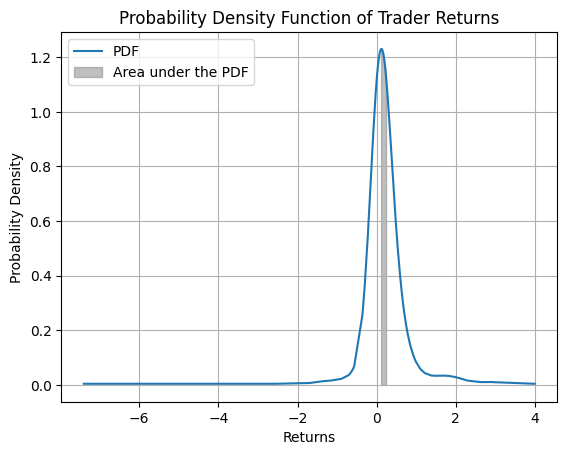

50295.210233010774

In [16]:
trader, data = pdfReturns(df, "0x35a9ebf9d86cfead962494eddab25ac8b640e9c9")
pdfPredictions(df, data, trader, 100000)

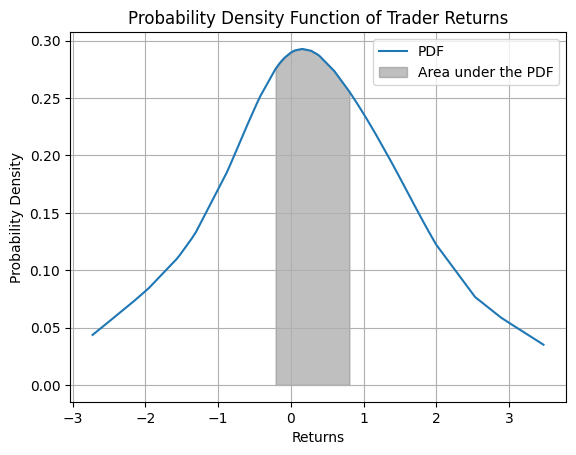

14176.01847858482

In [17]:
trader, data = pdfReturns(df, "0x67fa2be550cd331450557b64c8ccd6355f10a6bb", focus=True)
pdfPredictions(df, data, trader, 507239)

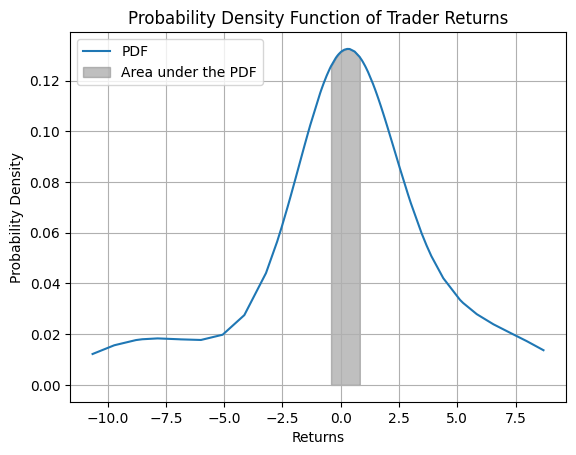

10104.716061378154

In [18]:
trader, data = pdfReturns(df, "0x67fa2be550cd331450557b64c8ccd6355f10a6bb", reduce=True)
pdfPredictions(df, data, trader, 507239)

In [28]:
def calculate_var_monte_carlo(data, trader, confidence_level=0.05, num_simulations=10000):
    returns = data[data["trader"] == trader]["return"].values.tolist()
    # Calculate the sample size for each simulation
    sample_size = len(returns)
    # Perform Monte Carlo simulation
    simulated_returns = np.random.choice(returns, size=(num_simulations, sample_size), replace=True)
    # Calculate the portfolio values for each simulation
    portfolio_values = np.cumprod(1 + simulated_returns, axis=1)
    # Sort the portfolio values to find the VaR
    sorted_values = np.sort(portfolio_values[:, -1])
    # Calculate the index corresponding to the confidence level
    confidence_index = int(confidence_level * num_simulations)
    # Calculate VaR as the negative value at the confidence index
    var = -sorted_values[confidence_index]
    return var

# Calculate the 5% VaR using Monte Carlo simulation with 10,000 simulations
var_5_monte_carlo = calculate_var_monte_carlo(df, "0xbbd2498a9e42af43062c1de268c8413601e1f8e4", confidence_level=0.95, num_simulations=10000)

print("5% VaR (Monte Carlo):", var_5_monte_carlo)

5% VaR (Monte Carlo): -9.46803720168154e+17


In [44]:
import numpy as np

def calculate_cvar_monte_carlo(data, trader, confidence_level=0.05, num_simulations=10000):
    returns = data[data["trader"] == trader]["return"].values.tolist()
    # Calculate the sample size for each simulation
    sample_size = len(returns)
    # Perform Monte Carlo simulation
    simulated_returns = np.random.choice(returns, size=(num_simulations, sample_size), replace=True)
    # Calculate the portfolio values for each simulation
    portfolio_values = np.cumprod(1 + simulated_returns, axis=1)
    # Sort the portfolio values to find the VaR
    sorted_values = np.sort(portfolio_values[:, -1])
    # Calculate the index corresponding to the confidence level
    confidence_index = int(confidence_level * num_simulations)
    # Calculate VaR as the negative value at the confidence index
    var = -sorted_values[confidence_index]
    # Calculate CVaR as the average of losses beyond VaR
    cvar = -np.mean(sorted_values[:confidence_index])
    return cvar

# Calculate the 5% CVaR using Monte Carlo simulation with 10,000 simulations
cvar_5_monte_carlo = calculate_cvar_monte_carlo(df, "0xbbd2498a9e42af43062c1de268c8413601e1f8e4", confidence_level=0.05, num_simulations=10000)

print("5% CVaR (Monte Carlo):", cvar_5_monte_carlo)


5% CVaR (Monte Carlo): 3.1535247671492875e+21
